# OCR and LDA on Lit Review Docs

In [47]:
import pdfminer as pdf
import os
import glob
import pickle as pkl
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim
import unicodedata
import re, string
from gensim import corpora, models
import gensim
from nltk import corpus
import re

In [2]:
# Get a blob of the pdf filenames, and turn them into a list
files = glob.glob('/Users/fm61/Documents/LitReviews/chatbot/*.pdf')

In [3]:
files[0:5]

['/Users/fm61/Documents/LitReviews/chatbot/1408.6762.pdf',
 '/Users/fm61/Documents/LitReviews/chatbot/1511.04108-2.pdf',
 '/Users/fm61/Documents/LitReviews/chatbot/1605.00090.pdf',
 '/Users/fm61/Documents/LitReviews/chatbot/1606.01541.pdf',
 '/Users/fm61/Documents/LitReviews/chatbot/1606.08340.pdf']

In [5]:
for x in files:
    dest_loc = x.replace('.pdf','.txt').replace('chatbot/','chatbot_text/')
    ocr_cmd = 'pdf2txt.py -o ' + dest_loc + ' -t text ' + x
    print ocr_cmd
    os.system(ocr_cmd)

pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1408.6762.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1408.6762.pdf
pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1511.04108-2.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1511.04108-2.pdf
pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1605.00090.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1605.00090.pdf
pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1606.01541.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1606.01541.pdf
pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1606.08340.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1606.08340.pdf
pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1609.04285.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1609.04285.pdf
pdf2txt.py -o /Users/fm61/Documents/LitReviews/chatbot_text/1609.06479.txt -t text /Users/fm61/Documents/LitReviews/chatbot/1609.06479.pdf
pdf2txt.py -o /Users/fm61

In [6]:
text_files = glob.glob('/Users/fm61/Documents/LitReviews/chatbot_text/*.txt')

In [7]:
text_files[0:5]

['/Users/fm61/Documents/LitReviews/chatbot_text/1408.6762.txt',
 '/Users/fm61/Documents/LitReviews/chatbot_text/1511.04108-2.txt',
 '/Users/fm61/Documents/LitReviews/chatbot_text/1605.00090.txt',
 '/Users/fm61/Documents/LitReviews/chatbot_text/1606.01541.txt',
 '/Users/fm61/Documents/LitReviews/chatbot_text/1606.08340.txt']

In [8]:
# Ok, now pull these text files in and lets do some lda

In [9]:
all_texts = []

In [10]:
for textpath in text_files:
    # Set an open string to place document text into
    all_doc_string = ''
    
    # Open the file and save contents to variable 'file_text'
    file_text = open(textpath, 'rb')
    
    # Read the lines of the tester into a variable. 
    file_lines = file_text.readlines()
    
    # Iterate through the lines, and append them to the string to make one big text blob
    for line in file_lines:
        all_doc_string = all_doc_string + line
        
    # Append the new string to the list of all files
    all_texts.append(all_doc_string)
    
    # String will reset next; close the file and flush the file buffer
    file_text.flush()
    file_text.close()

In [11]:
all_texts

[' \n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \n \n \n\nNikolaos Polatidis \n\n \n\nSupervisor: Dr Peter Hancox \n\n \n \n\nChatbot for admissions \n\n \n \n\nSubmitted for the degree of \n\n \n\nMSc in Internet Software Systems \n\n \n\nSchool of Computer Science \n\n \n\nUniversity of Birmingham \n\n \n \n \n \n \n \n \n\n1 \n\n\x0cAbstract \n\n \nThe communication of potential students with a university department is performed manually and it \nis a very time consuming procedure. The opportunity to communicate with on a one-to-one basis is \nhighly  valued.  However  with  many  hundreds  of  applications  each  year,  one-to-one  conversations \nare  not  feasible  in  most  cases.  The  communication  will  require  a  member  of  academic  staff  to \nexpend several hours to find suitable answers and contact each student. It would be useful to reduce \nhis costs and time. \n \nThe  project  aims  to  reduce  the  burden  on  the  head  of  admissions,  and  potentially  other  u

In [12]:
len(all_texts)

14

In [13]:
len(text_files)

14

In [15]:
# Hmmm. One off, but what the heck. Save it. 
pkl.dump(all_texts, open('all_texts_chatbot_litreview.pkl','wb'))

In [16]:
#####

In [17]:
df = pd.DataFrame(all_texts,columns=['orig_text'])

In [18]:
def preprocess_text(text):
    from nltk.corpus import stopwords
    from nltk.tokenize import LineTokenizer
    from nltk.tokenize import WhitespaceTokenizer
    from nltk.stem.porter import PorterStemmer
    
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    sw = list(stopwords.words())
    extra_stops = ['R', '', ' ', 'abstract', 'keywords', 'introduction', 'figure','morgan', 'harvey',
                   'david','elsweiler','northumbria','university','newcastle','united','kingdom','university',
                   'regensburg','germany', 'h', 'k', 'f', 'b', 'user', 'g', 'use']
    for word in extra_stops:
        sw.append(word)
    
    # Step 1 - Clean up unicode
    clean_string = ''
    doc = []
    #for x in text:
    #    if ord(x) <= 128:
    #        clean_string += x
    #clean_string = unicodedata.normalize('NFKD', clean_string.encode('utf-8', 'replace')).encode('ascii','replace')
            
    # Tokenize each line to get rid of the line carriages
    lines = LineTokenizer().tokenize(text.lower())
    
    clean_lines = []
    
    for line in lines:
        if line.startswith('e-mail') or line.startswith('doi') or line.startswith('For all other uses, contact') or line.find(' acm. isbn ') > 0:
            pass
        else:
            line_str = ''
            for char in line:
                #if ord(char) <= 127:
                if (char in string.ascii_letters) or char == ' ':
                    line_str += char
        
        # Clean up other undesirable characters
            if line_str != ' ' and line_str.rstrip().lstrip() not in sw:
                clean_lines.append(line_str)
    
    # Tokenize the lines
    for clean_line in clean_lines:
        tokens = WhitespaceTokenizer().tokenize(clean_line)
        stopped_tokens = [i for i in tokens if not i in sw]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        [doc.append(i) for i in stemmed_tokens]
        
    
    return doc

In [21]:
df.insert(df.shape[1], 'clean_text', df.orig_text.apply(preprocess_text))

In [22]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(df.clean_text)

In [23]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in df.clean_text]

In [24]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

In [372]:
ldamodel4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word = dictionary, passes=20)

In [373]:
ldamodel3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [25]:
print(ldamodel.print_topics(num_topics=10, num_words=4))

[(0, u'0.015*"chatbot" + 0.014*"question" + 0.013*"answer" + 0.008*"iot"'), (1, u'0.000*"learn" + 0.000*"model" + 0.000*"system" + 0.000*"use"'), (2, u'0.000*"messag" + 0.000*"learn" + 0.000*"respons" + 0.000*"use"'), (3, u'0.022*"model" + 0.018*"gener" + 0.017*"dialogu" + 0.013*"learn"'), (4, u'0.018*"system" + 0.015*"use" + 0.010*"question" + 0.010*"answer"'), (5, u'0.037*"learn" + 0.014*"polici" + 0.013*"deep" + 0.012*"network"'), (6, u'0.022*"model" + 0.022*"respons" + 0.015*"word" + 0.014*"topic"'), (7, u'0.039*"messag" + 0.022*"context" + 0.019*"respons" + 0.015*"data"'), (8, u'0.049*"bot" + 0.018*"revert" + 0.015*"interact" + 0.014*"edit"'), (9, u'0.000*"learn" + 0.000*"gener" + 0.000*"model" + 0.000*"system"')]


## Text generation

In [27]:
# Find the abstracts

In [29]:
df

,orig_text,clean_text
0,\n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \...,"[nikolao, polatidi, supervisor, dr, peter, han..."
1,6\n1\n0\n2\n\n \nr\na\n\n \n\nM\n8\n2\n\n \n \...,"[r, v, v, x, r, review, confer, paper, iclr, l..."
2,Response Selection with Topic Clues for Retrie...,"[respons, select, topic, clue, retrievalbas, c..."
3,Deep Reinforcement Learning for Dialogue Gener...,"[deep, reinforc, learn, dialogu, gener, jiwei,..."
4,Topic Aware Neural Response Generation\n\nChen...,"[topic, awar, neural, respons, gener, chen, xi..."
5,\n\nEven Good Bots Fight: The Case of Wikiped...,"[even, good, bot, fight, case, wikipedia, mile..."
6,6\n1\n0\n2\n\n \n\np\ne\nS\n1\n2\n\n \n\n \n \...,"[p, v, v, x, r, chatbot, greet, humancomput, c..."
7,Detecting Context Dependent Messages in a Conv...,"[detect, context, depend, messag, convers, env..."
8,Applying Chatbots to the Internet of Things: \...,"[appli, chatbot, internet, thing, opportun, ar..."
9,"Visual Dialog\n\nAbhishek Das1, Satwik Kottur2...","[visual, dialog, abhishek, satwik, kottur, khu..."


In [123]:
def tab_filter_regex(text):
    """
    Clean tabs out of a text field
    """
    # Get rid of digits and extraneous characters
    p = re.sub(r'(&(nbsp|amp);)+',' ',str(text))
    
    # Replace multiple spaces with a single space
    cleaned = re.sub(r'\s+', ' ', p)
  
    return cleaned.lstrip().rstrip()

In [124]:
def get_abstract(text):
    abstract_start = text.lower().find('abstract')
    introduction_start = text[abstract_start:].lower().find('introduction')
    return tab_filter_regex(text[(abstract_start + 9):(introduction_start - 1)])

In [125]:
# Now get the rest of the text
def get_rest_of_text(text):
    abstract_start = text.lower().find('abstract')
    introduction_start = text[abstract_start:].lower().find('introduction')
    return tab_filter_regex(text[introduction_start + 12:])

In [126]:
df.insert(df.shape[1],'abstract',df.orig_text.apply(get_abstract))

In [127]:
df.insert(df.shape[1],'body',df.orig_text.apply(get_rest_of_text))

In [128]:
df

,orig_text,clean_text,abstract,body
0,\n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \...,"[nikolao, polatidi, supervisor, dr, peter, han...",The communication of potential students with a...,ered by my parents. 3 Table of Contents Chapte...
1,6\n1\n0\n2\n\n \nr\na\n\n \n\nM\n8\n2\n\n \n \...,"[r, v, v, x, r, review, confer, paper, iclr, l...","In this paper, we apply a general deep learnin...",��cient attention mechanism in order to genera...
2,Response Selection with Topic Clues for Retrie...,"[respons, select, topic, clue, retrievalbas, c...",We consider incorporating topic information in...,are determined by themselves as well as the me...
3,Deep Reinforcement Learning for Dialogue Gener...,"[deep, reinforc, learn, dialogu, gener, jiwei,...",Recent neural models of dialogue generation of...,"erence, and ease of answering (re- lated to fo..."
4,Topic Aware Neural Response Generation\n\nChen...,"[topic, awar, neural, respons, gener, chen, xi...",We consider incorporating topic information in...,the generation of words in decoding. To increa...
5,\n\nEven Good Bots Fight: The Case of Wikiped...,"[even, good, bot, fight, case, wikipedia, mile...","In recent years, there has been a huge increas...",umb” bots may give rise to complex interaction...
6,6\n1\n0\n2\n\n \n\np\ne\nS\n1\n2\n\n \n\n \n \...,"[p, v, v, x, r, chatbot, greet, humancomput, c...",Both dialogue systems and chatbots aim at putt...,"ed, as they might be put to use in the human-c..."
7,Detecting Context Dependent Messages in a Conv...,"[detect, context, depend, messag, convers, env...",While automatic response generation for buildi...,context dependent messages. With the character...
8,Applying Chatbots to the Internet of Things: \...,"[appli, chatbot, internet, thing, opportun, ar...",��Internet of Things (IoT) is emerging as a si...,"ssed. Keywords—Internet of Things, Chatbots, H..."
9,"Visual Dialog\n\nAbhishek Das1, Satwik Kottur2...","[visual, dialog, abhishek, satwik, kottur, khu...","We introduce the task of Visual Dialog, which ...",baselines. We propose a retrieval-based evalua...


In [134]:
# Clean those
df.insert(df.shape[1],'abstract_pp', df.abstract.apply(preprocess_text))

In [135]:
df.insert(df.shape[1],'body_pp', df.body.apply(preprocess_text))

In [136]:
df.head()

,orig_text,clean_text,abstract,body,abstract_pp,body_pp
0,\n \n \n \n \n \n \n \n \n \n\n \n \n \n \n \...,"[nikolao, polatidi, supervisor, dr, peter, han...",The communication of potential students with a...,ered by my parents. 3 Table of Contents Chapte...,"[commun, potenti, student, depart, perform, ma...","[ere, parent, tabl, content, chapter, context,..."
1,6\n1\n0\n2\n\n \nr\na\n\n \n\nM\n8\n2\n\n \n \...,"[r, v, v, x, r, review, confer, paper, iclr, l...","In this paper, we apply a general deep learnin...",��cient attention mechanism in order to genera...,"[paper, appli, gener, deep, learn, dl, framewo...","[cient, attent, mechan, order, gener, answer, ..."
2,Response Selection with Topic Clues for Retrie...,"[respons, select, topic, clue, retrievalbas, c...",We consider incorporating topic information in...,are determined by themselves as well as the me...,"[consid, incorpor, topic, inform, messag, resp...","[determin, well, messag, vector, respons, vect..."
3,Deep Reinforcement Learning for Dialogue Gener...,"[deep, reinforc, learn, dialogu, gener, jiwei,...",Recent neural models of dialogue generation of...,"erence, and ease of answering (re- lated to fo...","[recent, neural, model, dialogu, gener, offer,...","[erenc, eas, answer, late, forwardlook, functi..."
4,Topic Aware Neural Response Generation\n\nChen...,"[topic, awar, neural, respons, gener, chen, xi...",We consider incorporating topic information in...,the generation of words in decoding. To increa...,"[consid, incorpor, topic, inform, sequencetose...","[gener, word, decod, increas, possibl, topic, ..."


## Now, try the text summarization

In [137]:
# So, try text summarization given the rest of the text. 
FN = 'vocabulary-embedding'

In [138]:
seed=73

In [231]:
vocab_size = 19722

In [232]:
embedding_dim = 100

In [233]:
lower = False # dont lower case the text

In [234]:
# Rename tokenized columns
heads = df['abstract']
desc = df['body']

In [235]:
heads

0     The communication of potential students with a...
1     In this paper, we apply a general deep learnin...
2     We consider incorporating topic information in...
3     Recent neural models of dialogue generation of...
4     We consider incorporating topic information in...
5     In recent years, there has been a huge increas...
6     Both dialogue systems and chatbots aim at putt...
7     While automatic response generation for buildi...
8     ��Internet of Things (IoT) is emerging as a si...
9     We introduce the task of Visual Dialog, which ...
10    We study response selection for multi-turn con...
11    We study multi-turn response generation in cha...
12                                         We give an o
13    We study reinforcement learning of chatbots wi...
Name: abstract, dtype: object

#### Build vocabulary

In [236]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [237]:
vocab, vocabcount = get_vocab(heads+desc)

In [238]:
# See the most popular tokens
print vocab[:50]
print '...',len(vocab)

['the', 'and', 'of', 'to', 'a', 'in', 'is', 'for', 'with', 'on', 'that', 'The', 'as', 'are', 'et', 'we', 'by', 'In', 'be', 'from', 'an', 'can', 'We', 'al.,', 'this', 'al.', 'which', 'not', 'it', '=', 'model', '.', 'or', 'A', 'learning', 'response', 'data', 'have', 'more', 'will', 'our', 'information', 'using', 'neural', 'at', 'each', 'two', 'topic', 'system', 'has']
... 19720


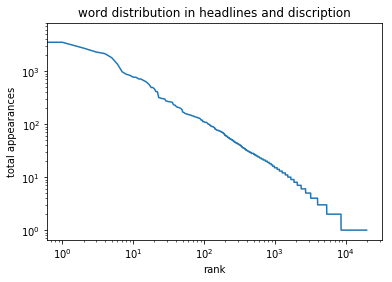

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

#### Index words

In [240]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [241]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [242]:
word2idx, idx2word = get_idx(vocab, vocabcount)

### Word Embedding

#### Read GloVe

In [243]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
#if not os.path.exists(glove_name):
#    path = 'glove.6B.zip'
#    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
#    !unzip {datadir}/{path}

In [244]:
glove_name

'/Users/fm61/.keras/datasets/glove.6B.100d.txt'

In [245]:
!wc -l {glove_name}

  400000 /Users/fm61/.keras/datasets/glove.6B.100d.txt


In [246]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [247]:
import numpy as np

In [248]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

In [249]:
glove_embedding_weights.std()

0.040815727600190289

In [250]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

### Embedding matrix

In [251]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

random-embedding/glove scale 0.0706949139514 std 0.0408294661504


In [252]:
len(idx2word)

19722

In [253]:
# Vocab wasn't big enough from sample pdf's to be 40,000. Changing it to vocab instead
vocab_size = 19722

In [255]:
# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

number of tokens, in small vocab, found in glove and copied to embedding 7966 0.403914410303


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [256]:
glove_thr = 0.5

In [257]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [258]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

# of glove substitutes found 18


In [259]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

0.699985542931 clicks => clicking
0.689336379355 secret => Intelligence
0.680689053196 rare => most
0.631476127374 Mustafa => Ahmed
0.609102761318 leveraged => derivatives
0.586243656511 slot => spot
0.577361925372 kinda => okay
0.57303534233 snapshots => images
0.569999467123 incapability => humanness
0.551016340239 coupling => equivalence


In [260]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

### Data exploration

In [261]:
heads[0].split()

['The',
 'communication',
 'of',
 'potential',
 'students',
 'with',
 'a',
 'university',
 'department',
 'is',
 'performed',
 'manually',
 'and',
 'it',
 'is',
 'a',
 'very',
 'time',
 'consuming',
 'procedure.',
 'The',
 'opportunity',
 'to',
 'communicate',
 'with',
 'on',
 'a',
 'one-to-one',
 'basis',
 'is',
 'highly',
 'valued.',
 'However',
 'with',
 'many',
 'hundreds',
 'of',
 'applications',
 'each',
 'year,',
 'one-to-one',
 'conversations',
 'are',
 'not',
 'feasible',
 'in',
 'most',
 'cases.',
 'The',
 'communication',
 'will',
 'require',
 'a',
 'member',
 'of',
 'academic',
 'staff',
 'to',
 'expend',
 'several',
 'hours',
 'to',
 'find',
 'suitable',
 'answers',
 'and',
 'contact',
 'each',
 'student.',
 'It',
 'would',
 'be',
 'useful',
 'to',
 'reduce',
 'his',
 'costs',
 'and',
 'time.',
 'The',
 'project',
 'aims',
 'to',
 'reduce',
 'the',
 'burden',
 'on',
 'the',
 'head',
 'of',
 'admissions,',
 'and',
 'potentially',
 'other',
 'users,',
 'by',
 'developing',
 

In [349]:
# Um, just remove the last token in the first one. 
Y = []
for headline in heads:
    item_list = []
    for token in headline.split():
        try:
            item_list.append(word2idx[token])
        except:
            print('Token not found: ' + token )
    Y.append(item_list)
        

Token not found: constan
Token not found: fo
Token not found: al
Token not found: convolut
Token not found: att


In [351]:
len(Y)

14

In [352]:
#Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

14

In [353]:
Y_df = pd.DataFrame(Y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fe79850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1341000d0>]], dtype=object)

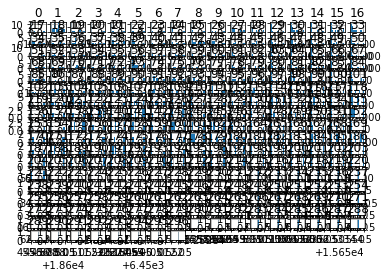

In [354]:
Y_df.hist()

In [356]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

KeyError: '\xac\x81cient'

In [357]:
len(heads)

14

In [358]:
len(desc)

14

In [362]:
# Um, just remove the last token in the first one. 
X = []
for d in desc:
    item_list = []
    for token in d.split():
        try:
            item_list.append(word2idx[token])
        except:
            print('Token not found: ' + token )
    X.append(item_list)
        

Token not found: ��cient
Token not found: erence,
Token not found: umb”
Token not found: ed,
Token not found: ssed.
Token not found: ng


In [359]:
X_df = pd.DataFrame(X)

In [363]:
len(X)

14

In [271]:
pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),open('/Users/fm61/Documents/Tutorials/How_to_make_a_text_summarizer/data/vocabulary-embedding.pkl','wb'),-1)

In [274]:
X

NameError: name 'X' is not defined

In [319]:
pickle.dump((X,Y),open('data/vocabulary-embedding.data.pkl','wb'),-1)

IOError: [Errno 2] No such file or directory: 'data/vocabulary-embedding.data.pkl'

# Train the model

In [364]:
FN = 'train'

In [365]:
import os

In [366]:
import keras
keras.__version__

'2.0.2'

In [367]:
FN0 = 'vocabulary-embedding'

In [368]:
FN1 = 'train'

In [369]:
maxlend=25 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512 # must be same as 160330-word-gen
rnn_layers = 3  # match FN1
batch_norm=False

In [370]:
activation_rnn_size = 40 if maxlend else 0

In [371]:
# training parameters
seed=73
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
LR = 1e-4
batch_size=64
nflips=10

In [372]:
nb_train_samples = 30000
nb_val_samples = 3000

## Read word embedding

In [329]:
embedding, idx2word, word2idx, glove_idx2idx = pickle.load(open('data/vocabulary-embedding.pkl','wb'))

IOError: [Errno 2] No such file or directory: 'data/vocabulary-embedding.pkl'

In [373]:
vocab_size, embedding_size = embedding.shape

In [331]:
with open('data/%s.data.pkl'%FN0, 'rb') as fp:
    X, Y = pickle.load(fp)

IOError: [Errno 2] No such file or directory: 'data/vocabulary-embedding.data.pkl'

In [374]:
nb_unknown_words = 10

In [375]:
print 'number of examples',len(X),len(Y)
print 'dimension of embedding space for words',embedding_size
print 'vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words
print 'total number of different words',len(idx2word), len(word2idx)
print 'number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx)
print 'number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx)

number of examples 14 14
dimension of embedding space for words 100
vocabulary size 19722 the last 10 words can be used as place holders for unknown/oov words
total number of different words 19722 19722
number of words outside vocabulary which we can substitue using glove similarity 18
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) -18


In [376]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [377]:
oov0 = vocab_size-nb_unknown_words

In [378]:
for i in range(oov0, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [383]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=seed)

In [ ]:
del X
del Y

In [384]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [385]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [386]:
def prt(label, x):
    print label+':',
    for w in x:
        print idx2word[w],
    print

In [389]:
i = 8
prt('H',Y_train[i])
prt('D',X_train[i])

H: We study response selection for multi-turn conversation in retrieval based chatbots. Existing works either ignores relationships among utterances, or misses important in- formation in context when matching a re- sponse with a highly abstract context vec- tor ﬁnally. We propose a new session based matching model to address both problems. The model ﬁrst matches a re- sponse with each utterance on multiple granularities, and distills important match- ing information from each pair as a vec- tor with
D: opera- tions. The vectors are then accumulated in a chronological order through a recur- rent neural network (RNN) which mod- els the relationships among the utterances. The ﬁnal matching score is calculated with the hidden states of the RNN. Empirical study on two public data sets shows that our model can signiﬁcantly outperform the state-of-the-art methods for response se- lection in multi-turn conversation. 1 Introduction Traditional research in human-computer conversa- tion focused o

In [ ]:
i = 334
prt('H',Y_test[i])
prt('D',X_test[i])

# Model

In [392]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

In [397]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,dropout=p_emb, weights=[embedding], mask_zero=True,
                    name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                dropout_W=p_W, dropout_U=p_U,
                name='lstm_%d'%(i+1)
                  )
    model.add(lstm)
    model.add(Dropout(p_dense,name='dropout_%d'%(i+1)))

/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, recurrent_dropout=0, name="lstm_1", dropout=0, return_sequences=True)`
/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, recurrent_dropout=0, name="lstm_2", dropout=0, return_sequences=True)`
/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, recurrent_dropout=0, name="lstm_3", dropout=0, return_sequences=True)`


In [398]:
from keras.layers.core import Lambda
import keras.backend as K

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))


class SimpleContext(Lambda):
    def __init__(self,**kwargs):
        super(SimpleContext, self).__init__(simple_context,**kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [403]:
activation_rnn_size

40

In [406]:
from keras.optimizers import Adam, RMSprop # usually I prefer Adam but article used rmsprop
# opt = Adam(lr=LR)  # keep calm and reduce learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [407]:
K.set_value(model.optimizer.lr,np.float32(LR))

In [408]:
def str_shape(x):
    return 'x'.join(map(str,x.shape))
    
def inspect_model(model):
    for i,l in enumerate(model.layers):
        print i, 'cls=%s name=%s'%(type(l).__name__, l.name)
        weights = l.get_weights()
        for weight in weights:
            print str_shape(weight),
        print

In [409]:
inspect_model(model)

0 cls=Embedding name=embedding_1
19722x100
1 cls=LSTM name=lstm_1
100x2048 512x2048 2048
2 cls=Dropout name=dropout_1

3 cls=LSTM name=lstm_2
512x2048 512x2048 2048
4 cls=Dropout name=dropout_2

5 cls=LSTM name=lstm_3
512x2048 512x2048 2048
6 cls=Dropout name=dropout_3



## Load

In [410]:
if FN1:
    model.load_weights('data/%s.hdf5'%FN1)

IOError: Unable to open file (Unable to open file: name = 'data/train.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

## Test

In [411]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [412]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

In [413]:
np.all(data[:,maxlend] == eos)

True

In [414]:
data.shape,map(len, samples)

((1, 50), [26])

In [421]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 50, 512)

In [422]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos],
               k=1, maxsample=maxlen, use_unk=True, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in xrange(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [list(start)]
    live_scores = [0]

    while live_k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk:
            for i in range(nb_unknown_words):
                cand_scores[:,vocab_size - 1 - i] = 1e20
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        ranks_dead = [r for r in ranks if r < n]
        ranks_live = [r - n for r in ranks if r >= n]
        
        dead_scores = [dead_scores[r] for r in ranks_dead]
        dead_samples = [dead_samples[r] for r in ranks_dead]
        
        live_scores = [live_scores[r] for r in ranks_live]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_live]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        zombie = [s[-1] == eos or len(s) > maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return dead_samples + live_samples, dead_scores + live_scores

In [423]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = map(len, samples)
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([prob[sample_length-maxlend-1] for prob, sample_length in zip(probs, sample_lengths)])

In [424]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < oov0 else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [425]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= oov0:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [426]:
import sys
import Levenshtein

def gensamples(skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    i = random.randint(0,len(X_test)-1)
    print 'HEAD:',' '.join(idx2word[w] for w in Y_test[i][:maxlenh])
    print 'DESC:',' '.join(idx2word[w] for w in X_test[i][:maxlend])
    sys.stdout.flush()

    print 'HEADS:'
    x = X_test[i]
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print score, ' '.join(words)
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print score, ' '.join(words)
        codes.append(code)

ImportError: No module named Levenshtein

In [428]:
pd.__path__

['/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/pandas']

In [429]:
gensamples(skips=2, batch_size=batch_size, k=10, temperature=1.)

NameError: name 'gensamples' is not defined

# Data Generator

In [430]:
def flip_headline(x, nflips=None, model=None, debug=False):
    """given a vectorized input (after `pad_sequences`) flip some of the words in the second half (headline)
    with words predicted by the model
    """
    if nflips is None or model is None or nflips <= 0:
        return x
    
    batch_size = len(x)
    assert np.all(x[:,maxlend] == eos)
    probs = model.predict(x, verbose=0, batch_size=batch_size)
    x_out = x.copy()
    for b in range(batch_size):
        # pick locations we want to flip
        # 0...maxlend-1 are descriptions and should be fixed
        # maxlend is eos and should be fixed
        flips = sorted(random.sample(xrange(maxlend+1,maxlen), nflips))
        if debug and b < debug:
            print b,
        for input_idx in flips:
            if x[b,input_idx] == empty or x[b,input_idx] == eos:
                continue
            # convert from input location to label location
            # the output at maxlend (when input is eos) is feed as input at maxlend+1
            label_idx = input_idx - (maxlend+1)
            prob = probs[b, label_idx]
            w = prob.argmax()
            if w == empty:  # replace accidental empty with oov
                w = oov0
            if debug and b < debug:
                print '%s => %s'%(idx2word[x_out[b,input_idx]],idx2word[w]),
            x_out[b,input_idx] = w
        if debug and b < debug:
            print
    return x_out

In [431]:
def conv_seq_labels(xds, xhs, nflips=None, model=None, debug=False):
    """description and hedlines are converted to padded input vectors. headlines are one-hot to label"""
    batch_size = len(xhs)
    assert len(xds) == batch_size
    x = [vocab_fold(lpadd(xd)+xh) for xd,xh in zip(xds,xhs)]  # the input does not have 2nd eos
    x = sequence.pad_sequences(x, maxlen=maxlen, value=empty, padding='post', truncating='post')
    x = flip_headline(x, nflips=nflips, model=model, debug=debug)
    
    y = np.zeros((batch_size, maxlenh, vocab_size))
    for i, xh in enumerate(xhs):
        xh = vocab_fold(xh) + [eos] + [empty]*maxlenh  # output does have a eos at end
        xh = xh[:maxlenh]
        y[i,:,:] = np_utils.to_categorical(xh, vocab_size)
        
    return x, y

In [432]:
def gen(Xd, Xh, batch_size=batch_size, nb_batches=None, nflips=None, model=None, debug=False, seed=seed):
    """yield batches. for training use nb_batches=None
    for validation generate deterministic results repeating every nb_batches
    
    while training it is good idea to flip once in a while the values of the headlines from the
    value taken from Xh to value generated by the model.
    """
    c = nb_batches if nb_batches else 0
    while True:
        xds = []
        xhs = []
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, sys.maxint)
        random.seed(c+123456789+seed)
        for b in range(batch_size):
            t = random.randint(0,len(Xd)-1)

            xd = Xd[t]
            s = random.randint(min(maxlend,len(xd)), max(maxlend,len(xd)))
            xds.append(xd[:s])
            
            xh = Xh[t]
            s = random.randint(min(maxlenh,len(xh)), max(maxlenh,len(xh)))
            xhs.append(xh[:s])

        # undo the seeding before we yield inorder not to affect the caller
        c+= 1
        random.seed(new_seed)

        yield conv_seq_labels(xds, xhs, nflips=nflips, model=model, debug=debug)

In [433]:
r = next(gen(X_train, Y_train, batch_size=batch_size))
r[0].shape, r[1].shape, len(r)

((64, 50), (64, 25, 19722), 2)

In [434]:
def test_gen(gen, n=5):
    Xtr,Ytr = next(gen)
    for i in range(n):
        assert Xtr[i,maxlend] == eos
        x = Xtr[i,:maxlend]
        y = Xtr[i,maxlend:]
        yy = Ytr[i,:]
        yy = np.where(yy)[1]
        prt('L',yy)
        prt('H',y)
        if maxlend:
            prt('D',x)

In [435]:
test_gen(gen(X_train, Y_train, batch_size=batch_size))

L: We give an o ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
H: ~ We give an o _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
D: The mechanisms of attention and memory (Graves et al., 2016) has been attracting much attention. Novel architectures and applications using deep RL were recognized in
L: We study reinforcement learning of chatbots with recurrent neural network archi- tectures when the rewards are noisy and expensive to obtain. For instance, a chat-
H: ~ We study reinforcement learning of chatbots with recurrent neural network archi- tectures when the rewards are noisy and expensive to obtain. For instance, a
D: our policy. RELATED WORK Recently there has been a surge of interest in deep learning approaches to reinforcement learning, many of them adopting Q-learning, e.g.
L: We give an o ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
H: ~ We give an o _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
D: list is boundless. New learning mechanisms have emerged, e.g., using unsupervised/semi-supervised/t

In [436]:
# Test flipping
test_gen(gen(X_train, Y_train, nflips=6, model=model, debug=False, batch_size=batch_size))

L: We give an o ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
H: ~ We i an o _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
D: The mechanisms of attention and memory (Graves et al., 2016) has been attracting much attention. Novel architectures and applications using deep RL were recognized in
L: We study reinforcement learning of chatbots with recurrent neural network archi- tectures when the rewards are noisy and expensive to obtain. For instance, a chat-
H: ~ Deep study reinforcement learning of chatbots with recurrent there network archi- tectures when the rewards are noisy e.g., expensive to ﬁrst ﬁrst ﬁrst a
D: our policy. RELATED WORK Recently there has been a surge of interest in deep learning approaches to reinforcement learning, many of them adopting Q-learning, e.g.
L: We give an o ~ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
H: ~ turns give 10 o _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
D: list is boundless. New learning mechanisms have emerged, e.g., using unsupervised/semi-supervised/tranf

In [437]:
valgen = gen(X_test, Y_test,nb_batches=3, batch_size=batch_size)

In [438]:
# Check that valgen repeats itself after nb_batches
for i in range(4):
    test_gen(valgen, n=1)

L: In recent years, there has been a huge increase in the number of bots online, varying from Web crawlers for search engines, to chatbots for
H: ~ In recent years, there has been a huge increase in the number of bots online, varying from Web crawlers for search engines, to chatbots
D: j are assigned so that y >= 0 for the majority of the ij interaction time. We analyze three properties of the trajectories: • Latency.
L: In recent years, there has been a huge increase in the number of bots online, varying from Web crawlers for search engines, to chatbots for
H: ~ In recent years, there has been a huge increase in the number of bots online, varying from Web crawlers for search engines, to chatbots
D: decreasing (error bars correspond to one standard error). This suggests that disagreement between bots is not becoming less common. In general, bots revert each other
L: We introduce the task of Visual Dialog, which requires an AI agent to hold a meaningful dialog with humans in natu- ral, 

# Train

In [439]:
history = {}

In [440]:
traingen = gen(X_train, Y_train, batch_size=batch_size, nflips=nflips, model=model)
valgen = gen(X_test, Y_test, nb_batches=nb_val_samples//batch_size, batch_size=batch_size)

In [441]:
r = next(traingen)
r[0].shape, r[1].shape, len(r)

((64, 50), (64, 25, 19722), 2)

In [442]:
for iteration in range(500):
    print 'Iteration', iteration
    h = model.fit_generator(traingen, samples_per_epoch=nb_train_samples,
                        nb_epoch=1, validation_data=valgen, nb_val_samples=nb_val_samples
                           )
    for k,v in h.history.iteritems():
        history[k] = history.get(k,[]) + v
    with open('data/%s.history.pkl'%FN,'wb') as fp:
        pickle.dump(history,fp,-1)
    model.save_weights('data/%s.hdf5'%FN, overwrite=True)
    gensamples(batch_size=batch_size)

Iteration 0


/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/Users/fm61/anaconda3/envs/txt_summ/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=30000, epochs=1, validation_steps=3000)`


Epoch 1/1


ValueError: Error when checking model target: expected dropout_3 to have shape (None, 50, 512) but got array with shape (64, 25, 19722)

# Predict: Next Notebook

In [443]:
FN = 'predict'

In [444]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

In [445]:
import keras
keras.__version__

'2.0.2'

In [446]:
FN0 = 'vocabulary-embedding'

In [447]:
FN1 = 'train'

In [448]:
maxlend=50 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512
rnn_layers = 3  # match FN1
batch_norm=False

In [449]:
activation_rnn_size = 40 if maxlend else 0

In [450]:
# training parameters
seed=73
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
batch_size=64

In [451]:
nb_train_samples = 30000
nb_val_samples = 3000

## Read word embedding

In [452]:
import cPickle as pickle

with open('data/%s.pkl'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

IOError: [Errno 2] No such file or directory: 'data/vocabulary-embedding.pkl'

In [453]:
nb_unknown_words = 10

In [454]:
print 'dimension of embedding space for words',embedding_size
print 'vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words
print 'total number of different words',len(idx2word), len(word2idx)
print 'number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx)
print 'number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx)

dimension of embedding space for words 100
vocabulary size 19722 the last 10 words can be used as place holders for unknown/oov words
total number of different words 19722 19722
number of words outside vocabulary which we can substitue using glove similarity 18
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) -18


In [455]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [456]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [457]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [458]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [459]:
def prt(label, x):
    print label+':',
    for w in x:
        print idx2word[w],
    print